<a href="https://colab.research.google.com/github/DanishFaraaz/Deep-Learning-Projects/blob/main/17_Pytorch_Cats_Vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:08<00:00, 106MB/s]


In [4]:
train_dir = './train'
test_dir = './test1'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [5]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in ./train is 25000
Number of images in ./test1 is 12500


In [6]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/cat.4301.jpg


In [7]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

In [8]:
class Dataset():
  def __init__(self, filelist, filepath, transform = None):
    self.filelist = filelist
    self.filepath = filepath
    self.transform = transform

  def __len__(self):
    return int(len(self.filelist))

  def __getitem__(self, index):
    imgpath = os.path.join(self.filepath, self.filelist[index])
    img = Image.open(imgpath)

    if "dog" in imgpath:
      label = 1
    else:
      label = 0

    if self.transform is not None:
      img = self.transform(img)

    return (img, label)

In [9]:
train = Dataset(train_files, train_dir, transformations)
test = Dataset(test_files, test_dir, transformations)

In [10]:
train.__getitem__(0)

(tensor([[[0.3412, 0.3961, 0.4980,  ..., 0.0745, 0.0667, 0.0627],
          [0.3490, 0.3804, 0.4941,  ..., 0.0784, 0.0667, 0.0627],
          [0.3529, 0.3686, 0.4902,  ..., 0.0784, 0.0667, 0.0627],
          ...,
          [0.4235, 0.4235, 0.3333,  ..., 0.5098, 0.5137, 0.4941],
          [0.4000, 0.4000, 0.2549,  ..., 0.5098, 0.5255, 0.5137],
          [0.3725, 0.3647, 0.1725,  ..., 0.5176, 0.5333, 0.4863]],
 
         [[0.3529, 0.4118, 0.5255,  ..., 0.0392, 0.0392, 0.0392],
          [0.3569, 0.4000, 0.5294,  ..., 0.0431, 0.0392, 0.0392],
          [0.3686, 0.3882, 0.5333,  ..., 0.0431, 0.0392, 0.0392],
          ...,
          [0.1294, 0.1333, 0.1216,  ..., 0.4706, 0.4784, 0.4627],
          [0.1294, 0.1333, 0.1020,  ..., 0.4627, 0.4745, 0.4588],
          [0.1255, 0.1216, 0.0784,  ..., 0.4667, 0.4784, 0.4196]],
 
         [[0.3765, 0.4235, 0.5373,  ..., 0.0353, 0.0392, 0.0392],
          [0.3961, 0.4196, 0.5373,  ..., 0.0392, 0.0392, 0.0392],
          [0.4078, 0.4118, 0.5373,  ...,

In [11]:
print(test.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


In [12]:
train, val = torch.utils.data.random_split(train, [20000,5000])

In [13]:
print(len(train))
print(len(val))

20000
5000


In [15]:
# Creating an array of the labels
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val))]

<Axes: ylabel='count'>

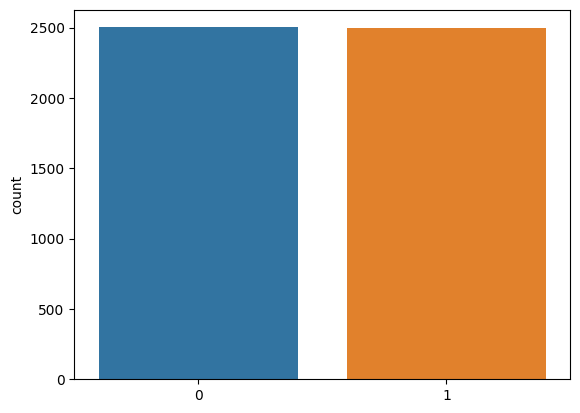

In [16]:
import seaborn as sns

sns.countplot(x=val_set_class_count)

In [17]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle = True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle = False)

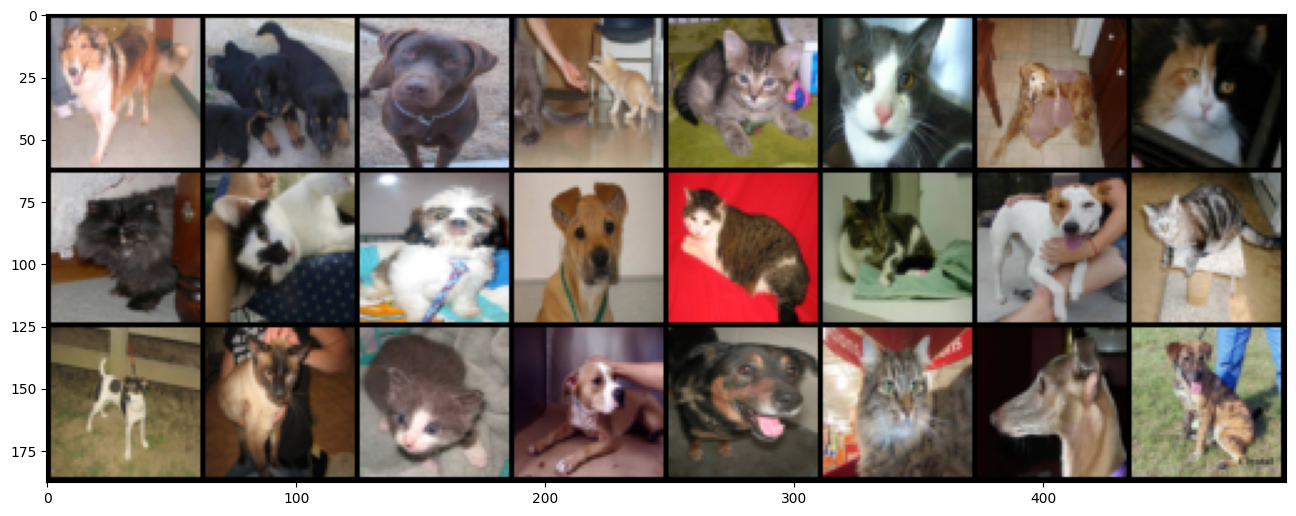

In [18]:
samples, labels = iter(train_dataset).__next__()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [19]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(3,16,3), nn.ReLU(), nn.MaxPool2d(2,2))
    self.conv2 = nn.Sequential(nn.Conv2d(16,32,3), nn.ReLU(), nn.MaxPool2d(2,2))
    self.conv3 = nn.Sequential(nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2,2))

    self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*5*5, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
    self.fc2 = nn.Sequential(nn.Linear(128, 2))

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.softmax(x, dim=1)

In [20]:
model = CNN()
model.cuda()
summary(model, (3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

In [21]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

In [22]:
type(train_dataset) #Check to make sure it is a DataLoader

torch.utils.data.dataloader.DataLoader

**Using TQDM for a Keras-style training**

In [24]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
  model.train()
  total = 0
  correct = 0
  counter = 0
  train_running_loss = 0

  with tqdm(train_dataset, unit="batch") as tepoch:
    tepoch.set_description(f'Epoch {epoch+1}/{epoch}')

    for data, label in tepoch:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

      train_running_loss += loss.item() * data.size(0)

      _, pred = torch.max(output.data, 1)

      total += label.size(0)
      correct += (pred == label).sum().item()

    train_accuracy.append(correct/total)
    train_loss.append(train_running_loss/len(train_dataset))
    print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
    print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

  if epoch%1 == 0:
    model.eval()
    total = 0
    correct = 0
    val_running_loss = 0

    with torch.no_grad():
      for val_data, val_label in val_dataset:
        val_data, val_label = val_data.to(device), val_label.to(device)
        val_output = model(val_data)
        loss_val = criterion(val_output, val_label)

        val_running_loss += loss_val.item() * val_data.size(0)
        _, pred = torch.max(val_output.data, 1)
        total += val_label.size(0)
        correct += (pred == val_label).sum().item()

      val_accuracy.append(correct/total)
      val_loss.append(val_running_loss/len(val_dataset))
      print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
      print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

<ipython-input-24-6d3e00d111f0>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.61765
Epoch 1 Training Loss = 20.655971086120605
Epoch 1 Validation Accuracy = 0.6676
Epoch 1 Validation Loss = 19.51555126943406


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.70395
Epoch 2 Training Loss = 18.806753604125976
Epoch 2 Validation Accuracy = 0.723
Epoch 2 Validation Loss = 18.120202804067333


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.737
Epoch 3 Training Loss = 17.873593927001952
Epoch 3 Validation Accuracy = 0.743
Epoch 3 Validation Loss = 17.664399891142633


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.7627
Epoch 4 Training Loss = 17.142643078613283
Epoch 4 Validation Accuracy = 0.7448
Epoch 4 Validation Loss = 17.54437035663872


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.7786
Epoch 5 Training Loss = 16.738102770996093
Epoch 5 Validation Accuracy = 0.765
Epoch 5 Validation Loss = 17.07640640598953


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.7883
Epoch 6 Training Loss = 16.40035603637695
Epoch 6 Validation Accuracy = 0.7768
Epoch 6 Validation Loss = 16.698414419866673


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.80325
Epoch 7 Training Loss = 16.00725262298584
Epoch 7 Validation Accuracy = 0.7824
Epoch 7 Validation Loss = 16.53934757117253


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.81645
Epoch 8 Training Loss = 15.636376852416992
Epoch 8 Validation Accuracy = 0.7878
Epoch 8 Validation Loss = 16.39144615155117


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.8263
Epoch 9 Training Loss = 15.336317784118652
Epoch 9 Validation Accuracy = 0.7826
Epoch 9 Validation Loss = 16.631274135249434


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.8403
Epoch 10 Training Loss = 14.925007525634765
Epoch 10 Validation Accuracy = 0.7922
Epoch 10 Validation Loss = 16.14912550464557


In [25]:
train_loss

[20.655971086120605,
 18.806753604125976,
 17.873593927001952,
 17.142643078613283,
 16.738102770996093,
 16.40035603637695,
 16.00725262298584,
 15.636376852416992,
 15.336317784118652,
 14.925007525634765]

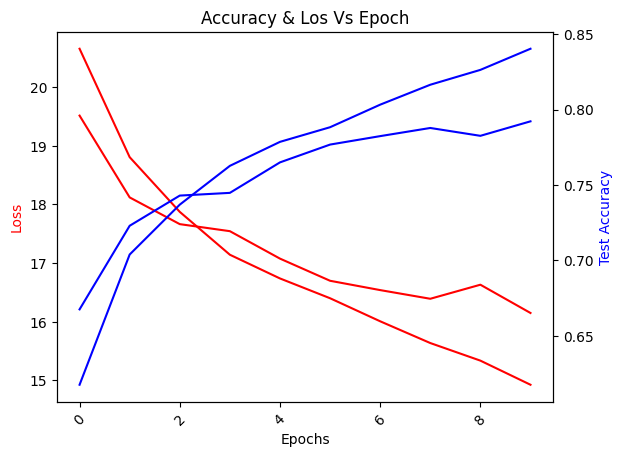

In [27]:
epoch_log = [*range(epochs)]

fig, ax1 = plt.subplots()

plt.title('Accuracy & Los Vs Epoch')
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')

ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuracy, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [28]:
PATH = './cat_vs_dog_10_epochs.pth'
torch.save(model.state_dict(), PATH)

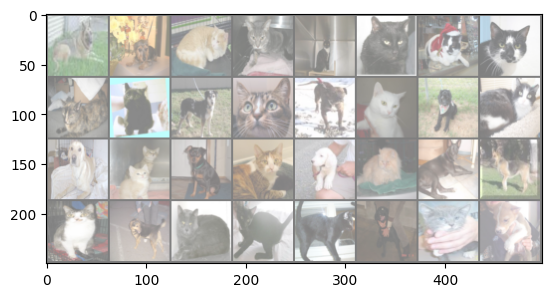

Groun Truth:  11000000001010101010101101000101


In [30]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(val_dataset)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images))
print('Groun Truth: ',''.join('%1s' %labels[j].numpy() for j in range(32)))

In [31]:
model = CNN()
model.to(device)

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

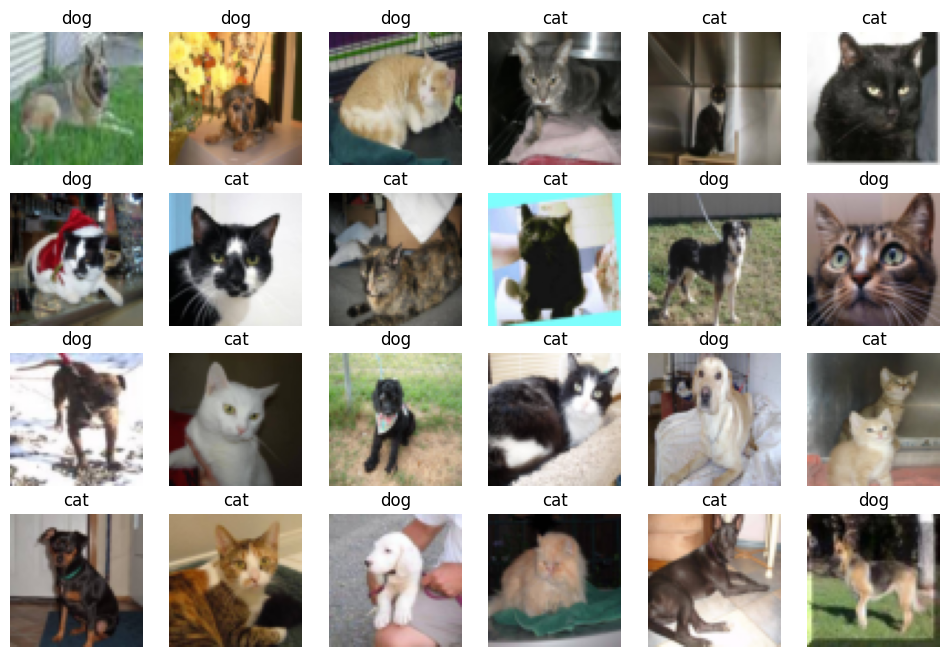

In [32]:
samples, _ = iter(val_dataset).__next__()
samples = samples.to(device)

fig = plt.figure(figsize=(12,8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
  plt.subplot(4,6,num+1)
  plt.title(ad[pred[num]])
  plt.axis('off')
  sample = sample.cpu().numpy()
  plt.imshow(np.transpose(sample, (1,2,0)))